# Finetune Stable Diffusion and generate images with Intel Gaudi
In this tutorial, we will go through how to finetune a stable diffusion model and generate images with Intel Gaudi(HPU). Moreover, we will show how to adapt an existing HPU example to use Ray. Once you learned how to make the adaption, you can easily access more models and optimizations that has been developed for HPU by "Ray-ifying" examples from [optimum-habana/examples](https://github.com/huggingface/optimum-habana/tree/main/examples) and [Model References](https://github.com/HabanaAI/Model-References)!

Now, let's see how we can "Ray-ify" this [stable diffusion example](https://github.com/huggingface/optimum-habana/tree/main/examples/stable-diffusion)

## Configuration
A node with Gaudi/Gaudi2 installed is required to run this example. Both Gaudi and Gaudi2 have 8 HPUs.

We recommend using a prebuilt container to run these examples. To run a container, you need Docker. See [Install Docker Engine](https://docs.docker.com/engine/install/) for installation instructions.

Next, follow [Run Using Containers](https://docs.habana.ai/en/latest/Installation_Guide/Bare_Metal_Fresh_OS.html?highlight=installer#run-using-containers) to install the Gaudi drivers and container runtime.

Then, start the Gaudi container:
```bash
docker pull vault.habana.ai/gaudi-docker/1.15.1/ubuntu22.04/habanalabs/pytorch-installer-2.2.0:latest
docker run -it --runtime=habana -e HABANA_VISIBLE_DEVICES=all -e OMPI_MCA_btl_vader_single_copy_mechanism=none --cap-add=sys_nice --net=host --ipc=host vault.habana.ai/gaudi-docker/1.15.1/ubuntu22.04/habanalabs/pytorch-installer-2.2.0:latest
```

Inside the container, clone [Optimum-Habana](https://github.com/huggingface/optimum-habana/) and install the dependencies:
```bash
git clone https://github.com/huggingface/optimum-habana.git
pip install ray[train,serve] optimum-habana
cd optimum-habana/
pip install -r examples/stable-diffusion/requirements.txt
pip install -r examples/stable-diffusion/training/requirements.txt
```

## Fine-tuning with Textual Inversion
First, let's start with fine-tuning. Check `examples/stable-diffusion/training/textual_inversion.py` which fine-tunes a Stable Diffusion model on HPU. You can follow [this document](https://github.com/huggingface/optimum-habana/blob/main/examples/stable-diffusion/training/README.md#textual-inversion) and try it once without using Ray.

In order to run this script on Ray, we need to make some changes. But don't worry, it's actually pretty simple. Basically, we just need to identify the main training loop, and run it in TorchTrainer.

First, check this block at the end of the file:
```python
if __name__ == "__main__":
    main()
```

Originally, this script will be started by MPI if multiple workers are used. But with Ray, we should setup TorchTrainer and supply a main function, which is `main()` in this example.

Therefore, it becomes straight-forward to make these changes:
```python
if __name__ == "__main__":
    import ray
    from ray import train
    from ray.train import ScalingConfig, Checkpoint, CheckpointConfig, RunConfig
    from ray.train.torch import TorchTrainer, TorchConfig

    ray.init(address="auto")

    # Configure computation resources
    # In ScalingConfig, require an HPU for each worker
    scaling_config = ScalingConfig(num_workers=1, resources_per_worker={"CPU": 1, "HPU": 1})
    # Set backend to hccl in TorchConfig
    torch_config = TorchConfig(backend = "hccl")
    # Initialize a Ray TorchTrainer
    trainer = TorchTrainer(
        train_loop_per_worker=main,
        torch_config=torch_config,
        scaling_config=scaling_config,
    )

    result = trainer.fit()
```

Before we try to run, we need to inspect the `main` function to see if it can work in such way. As we skim through the function, it's clear that it does not take any input parameters, but it calls `parse_args` to get all configurations. Originally, these configurations are set in command line by MPI. But because we switch to Ray to start the workers, command line arguments are no longer accessible. Therefore, `parse_args` should be called in the main program and passed to `main` function.

Apart from this, no other changes are necessary. By inserting the following code, you can now run the script on Ray.

In [ ]:
# Replace lines below:
# def main():
#     args = parse_args()
# with these lines:
def main(config):
    args = config["args"]

In [ ]:
# Replace lines below:
# if __name__ == "__main__":
#     main()
# with these lines:
if __name__ == "__main__":
    import ray
    from ray import train
    from ray.train import ScalingConfig, Checkpoint, CheckpointConfig, RunConfig
    from ray.train.torch import TorchTrainer, TorchConfig

    ray.init(address="auto")

    # Configure computation resources
    # In ScalingConfig, require an HPU for each worker
    scaling_config = ScalingConfig(num_workers=1, resources_per_worker={"CPU": 1, "HPU": 1})
    # Set backend to hccl in TorchConfig
    torch_config = TorchConfig(backend = "hccl")
    # Initialize a Ray TorchTrainer
    trainer = TorchTrainer(
        train_loop_per_worker=main,
		train_loop_config={"args": parse_args()},
        torch_config=torch_config,
        scaling_config=scaling_config,
    )

    result = trainer.fit()

One last thing: remember to use absolute path in the command line arguments. The reason is similar to why we move `parse_args` out, Ray's workers do not share the current working directory. Now, you can run the fine-tuning of Stable Diffusion on Ray!
An example command:
```bash
python /root/optimum-habana/examples/stable-diffusion/training/textual_inversion.py \
  --pretrained_model_name_or_path runwayml/stable-diffusion-v1-5 \
  --train_data_dir "/root/cat" \
  --learnable_property object \
  --placeholder_token "<cat-toy>" \
  --initializer_token toy \
  --resolution 512 \
  --train_batch_size 4 \
  --max_train_steps 3000 \
  --learning_rate 5.0e-04 \
  --scale_lr \
  --lr_scheduler constant \
  --lr_warmup_steps 0 \
  --output_dir /tmp/textual_inversion_cat \
  --save_as_full_pipeline \
  --gaudi_config_name Habana/stable-diffusion \
  --throughput_warmup_steps 3
```

The output of the example command:
```bash
Training started with configuration:
╭───────────────────────────────────────────────╮
│ Training config                               │
├───────────────────────────────────────────────┤
│ train_loop_config/args   ...t_warmup_steps=3) │
╰───────────────────────────────────────────────╯
(RayTrainWorker pid=15683) Setting up process group for: env:// [rank=0, world_size=1]
(TorchTrainer pid=15530) Started distributed worker processes: 
(TorchTrainer pid=15530) - (ip=172.17.0.2, pid=15683) world_rank=0, local_rank=0, node_rank=0
(RayTrainWorker pid=15683) [WARNING|utils.py:185] 2024-05-09 05:21:13,961 >> optimum-habana v1.10.4 has been validated for SynapseAI v1.14.0 but habana-frameworks v1.15.1.15 was found, this could lead to undefined behavior!
(RayTrainWorker pid=15683) [WARNING|utils.py:198] 2024-05-09 05:21:15,401 >> optimum-habana v1.10.4 has been validated for SynapseAI v1.14.0 but the driver version is v1.15.0, this could lead to undefined behavior!
(RayTrainWorker pid=15683) /usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
(RayTrainWorker pid=15683)   torch.utils._pytree._register_pytree_node(
(RayTrainWorker pid=15683) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(RayTrainWorker pid=15683)   warnings.warn(
(RayTrainWorker pid=15683) 05/09/2024 05:21:15 - INFO - __main__ - Distributed environment: MULTI_HPU  Backend: hccl
(RayTrainWorker pid=15683) Num processes: 1
(RayTrainWorker pid=15683) Process index: 0
(RayTrainWorker pid=15683) Local process index: 0
(RayTrainWorker pid=15683) Device: hpu
(RayTrainWorker pid=15683) 
(RayTrainWorker pid=15683) Mixed precision type: bf16
(RayTrainWorker pid=15683) 
(RayTrainWorker pid=15683) {'timestep_spacing', 'rescale_betas_zero_snr', 'dynamic_thresholding_ratio', 'prediction_type', 'thresholding', 'sample_max_value', 'clip_sample_range'} was not found in config. Values will be initialized to default values.
(RayTrainWorker pid=15683) ============================= HABANA PT BRIDGE CONFIGURATION =========================== 
(RayTrainWorker pid=15683)  PT_HPU_LAZY_MODE = 1
(RayTrainWorker pid=15683)  PT_RECIPE_CACHE_PATH = 
(RayTrainWorker pid=15683)  PT_CACHE_FOLDER_DELETE = 0
(RayTrainWorker pid=15683)  PT_HPU_RECIPE_CACHE_CONFIG = 
(RayTrainWorker pid=15683)  PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
(RayTrainWorker pid=15683)  PT_HPU_LAZY_ACC_PAR_MODE = 0
(RayTrainWorker pid=15683)  PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
(RayTrainWorker pid=15683) ---------------------------: System Configuration :---------------------------
(RayTrainWorker pid=15683) Num CPU Cores : 152
(RayTrainWorker pid=15683) CPU RAM       : 1056440348 KB
(RayTrainWorker pid=15683) ------------------------------------------------------------------------------
(RayTrainWorker pid=15683) {'scaling_factor', 'force_upcast'} was not found in config. Values will be initialized to default values.
(RayTrainWorker pid=15683) {'addition_embed_type', 'resnet_out_scale_factor', 'transformer_layers_per_block', 'attention_type', 'conv_out_kernel', 'time_embedding_type', 'addition_embed_type_num_heads', 'dropout', 'only_cross_attention', 'projection_class_embeddings_input_dim', 'num_attention_heads', 'upcast_attention', 'reverse_transformer_layers_per_block', 'resnet_time_scale_shift', 'resnet_skip_time_act', 'time_embedding_act_fn', 'class_embeddings_concat', 'time_cond_proj_dim', 'num_class_embeds', 'mid_block_type', 'cross_attention_norm', 'addition_time_embed_dim', 'dual_cross_attention', 'mid_block_only_cross_attention', 'encoder_hid_dim_type', 'time_embedding_dim', 'class_embed_type', 'conv_in_kernel', 'timestep_post_act', 'encoder_hid_dim', 'use_linear_projection'} was not found in config. Values will be initialized to default values.
(RayTrainWorker pid=15683) 05/09/2024 05:21:20 - INFO - __main__ - ***** Running training *****
(RayTrainWorker pid=15683) 05/09/2024 05:21:20 - INFO - __main__ -   Num examples = 600
(RayTrainWorker pid=15683) 05/09/2024 05:21:20 - INFO - __main__ -   Num Epochs = 20
(RayTrainWorker pid=15683) 05/09/2024 05:21:20 - INFO - __main__ -   Instantaneous batch size per device = 4
(RayTrainWorker pid=15683) 05/09/2024 05:21:20 - INFO - __main__ -   Total train batch size (w. parallel, distributed & accumulation) = 4
(RayTrainWorker pid=15683) 05/09/2024 05:21:20 - INFO - __main__ -   Gradient Accumulation steps = 1
(RayTrainWorker pid=15683) 05/09/2024 05:21:20 - INFO - __main__ -   Total optimization steps = 3000
Steps:   0%|          | 0/3000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/habana_frameworks/torch/hpu/__init__.py:158: UserWarning: torch.hpu.setDeterministic is deprecated and will be removed in next release. Please use torch.use_deterministic_algorithms instead.
(RayTrainWorker pid=15683)   warnings.warn(
(RayTrainWorker pid=15683) [2024-05-09 05:21:20,951] [INFO] [real_accelerator.py:178:get_accelerator] Setting ds_accelerator to hpu (auto detect)
Steps:   0%|          | 1/3000 [00:51<42:39:29, 51.21s/it, loss=0.138, lr=0.002]
...
...
...
(RayTrainWorker pid=15683) 05/09/2024 05:40:25 - INFO - __main__ - Saved state to /tmp/textual_inversion_cat/checkpoint-3000
Steps: 100%|██████████| 3000/3000 [19:04<00:00,  3.20it/s, loss=0.0261, lr=0.002]05/09/2024 05:40:25 - INFO - __main__ - Throughput = 11.083350060523712 samples/s
(RayTrainWorker pid=15683) 05/09/2024 05:40:25 - INFO - __main__ - Train runtime = 1081.622427743976 seconds
(RayTrainWorker pid=15683) /usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
(RayTrainWorker pid=15683)   warnings.warn(
(RayTrainWorker pid=15683) {'use_habana', 'requires_safety_checker', 'image_encoder', 'use_hpu_graphs', 'gaudi_config', 'bf16_full_eval'} was not found in config. Values will be initialized to default values.
(RayTrainWorker pid=15683) 
Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of runwayml/stable-diffusion-v1-5.
(RayTrainWorker pid=15683) Loaded safety_checker as StableDiffusionSafetyChecker from `safety_checker` subfolder of runwayml/stable-diffusion-v1-5.
(RayTrainWorker pid=15683) 
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 26.90it/s]
(RayTrainWorker pid=15683) [INFO|pipeline_utils.py:193] 2024-05-09 05:40:25,683 >> Running on CPU.
(RayTrainWorker pid=15683) Configuration saved in /tmp/textual_inversion_cat/vae/config.json
(RayTrainWorker pid=15683) Model weights saved in /tmp/textual_inversion_cat/vae/diffusion_pytorch_model.safetensors
(RayTrainWorker pid=15683) Configuration saved in /tmp/textual_inversion_cat/unet/config.json
(RayTrainWorker pid=15683) Model weights saved in /tmp/textual_inversion_cat/unet/diffusion_pytorch_model.safetensors
(RayTrainWorker pid=15683) Configuration saved in /tmp/textual_inversion_cat/scheduler/scheduler_config.json
(RayTrainWorker pid=15683) Configuration saved in /tmp/textual_inversion_cat/model_index.json
(RayTrainWorker pid=15683) 05/09/2024 05:40:31 - INFO - __main__ - Saving embeddings
Steps: 100%|██████████| 3000/3000 [19:10<00:00,  2.61it/s, loss=0.0261, lr=0.002]

Training completed after 0 iterations at 2024-05-09 05:40:33. Total running time: 19min 30s
2024-05-09 05:40:33,116	INFO tune.py:1007 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/TorchTrainer_2024-05-09_05-21-02' in 0.0022s.
```

One of the advantages of Ray is that it scales easily. In this example, we can easily scale the training to multiple workers by changing `num_workers` in `ScalingConfig`. Torch distributed environment will be automatically initialized in Ray.

## Serve the fine-tuned model on Ray
Now that we have fine-tuned a Stable Diffusion model, we can serve it for image generation. The code below loads the fine-tuned model and generates an image.

In [ ]:
import torch
from optimum.habana.diffusers import GaudiStableDiffusionPipeline
model_id = "/tmp/textual_inversion_cat/"
pipe = GaudiStableDiffusionPipeline.from_pretrained(
  model_id,
  torch_dtype=torch.bfloat16,
  use_habana=True,
  use_hpu_graphs=True,
  gaudi_config="Habana/stable-diffusion",
)
prompt = "a <cat-toy> is dancing on the grass."
image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
image.save("cat-backpack.png")

We can easily use Ray Serve to deploy it as an HTTP service. The code below is modified from this [example](https://docs.ray.io/en/master/serve/tutorials/stable-diffusion.html). Save it to `gaudi_sd_deploy.py`, and use `serve run gaudi_sd_deploy:entrypoint` to start the Serve application.

In [ ]:
import torch
from optimum.habana.diffusers import GaudiStableDiffusionPipeline
from io import BytesIO
from fastapi import FastAPI
from fastapi.responses import Response

from ray import serve
from ray.serve.handle import DeploymentHandle


app = FastAPI()


@serve.deployment(num_replicas=1)
@serve.ingress(app)
class APIIngress:
    def __init__(self, diffusion_model_handle: DeploymentHandle) -> None:
        self.handle = diffusion_model_handle

    @app.get(
        "/imagine",
        responses={200: {"content": {"image/png": {}}}},
        response_class=Response,
    )
    async def generate(self, prompt: str, img_size: int = 512):
        assert len(prompt), "prompt parameter cannot be empty"

        image = await self.handle.generate.remote(prompt, img_size=img_size)
        file_stream = BytesIO()
        image.save(file_stream, "PNG")
        return Response(content=file_stream.getvalue(), media_type="image/png")


@serve.deployment(
    ray_actor_options={"resources": {"HPU": 1}}
)
class GaudiStableDiffusion:
    def __init__(self, model_id):
        self.pipe = GaudiStableDiffusionPipeline.from_pretrained(
            model_id,
            torch_dtype=torch.bfloat16,
            use_habana=True,
            use_hpu_graphs=True,
            gaudi_config="Habana/stable-diffusion",
        )

    def generate(self, prompt: str, img_size: int = 512):
        assert len(prompt), "prompt parameter cannot be empty"

        image = self.pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
		return image


entrypoint = APIIngress.bind(GaudiStableDiffusion.bind("/tmp/textual_inversion_cat/"))

After you successfully deployed this Serve application, run the code below to generate an image.

In [ ]:
import requests

prompt = "a <cat-toy> is dancing on the grass."
input = "%20".join(prompt.split(" "))
resp = requests.get(f"http://127.0.0.1:8000/imagine?prompt={input}")
with open("output.png", 'wb') as f:
    f.write(resp.content)

Here is an example image:

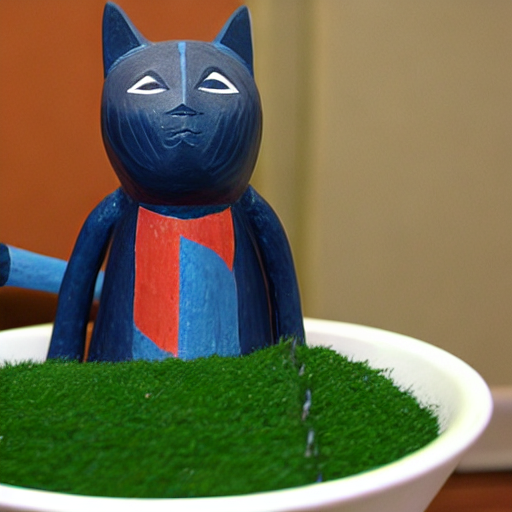

In [1]:
from IPython.display import Image
Image(filename='ouput.png')